# 5-class CNN Classifier for Spoof Images

Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
from PIL import Image
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score, accuracy_score
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
from sklearn.metrics import recall_score
from tqdm import tqdm

File Prep

Training the Classifier

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Training the Model

In [ ]:
import torch
from torch.utils.data import Dataset
import json
from PIL import Image
import os

class SpoofDataset(Dataset):
    def __init__(self, data_dir, label_file, transform=None):
        """
        Args:
            data_dir: Directory with all the images, separated into 'live' and 'spoof' subdirectories.
            label_file: Path to JSON file with labels, where label 0 indicates 'live' and others indicate 'spoof'.
            transform: Optional transform.
        """
        self.data_dir = data_dir
        self.transform = transform
        with open(label_file, 'r') as f:
            self.labels = json.load(f)

        self.img_paths = []
        self.img_labels = []
        for img_name, label in self.labels.items():
            # Correct the file extension from .png to .jpg
            img_name = img_name.replace('.png', '.jpg')
            subfolder = 'live' if label == 0 else 'spoof'
            full_path = os.path.join(self.data_dir, subfolder, img_name)
            if os.path.exists(full_path):
                self.img_paths.append(full_path)
                self.img_labels.append(label)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
data_dir = 'preprocessed_data'
label_file = 'train_label.json'

dataset = SpoofDataset(data_dir=data_dir, label_file=label_file, transform=data_transforms)

# Split dataset into train and validation sets
num_train = int(len(dataset) * 0.8)
num_val = len(dataset) - num_train
train_dataset, val_dataset = random_split(dataset, [num_train, num_val])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)
}

model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)

In [ ]:
device

device(type='cuda')

In [ ]:
print(num_train)

42933


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize best metrics tracking
best_metrics = {
    'epoch': 0,
    'val_loss': float('inf'),
    'val_accuracy': 0,
    'val_precision': 0,
    'val_recall': 0,
    'val_f1': 0,
}

In [ ]:
# Training loop
for epoch in range(10):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        all_preds = []
        all_labels = []

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_accuracy = accuracy_score(all_labels, all_preds)
        epoch_precision = precision_score(all_labels, all_preds, zero_division=0, average='macro')
        epoch_recall = recall_score(all_labels, all_preds, zero_division=0, average='macro')
        epoch_f1 = f1_score(all_labels, all_preds, zero_division=0, average='macro')

        print(f'Epoch {epoch+1} {phase.upper()} Loss: {epoch_loss:.4f} Accuracy: {epoch_accuracy:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1: {epoch_f1:.4f}')

        # Update best metrics for validation phase
        if phase == 'val' and (epoch_loss < best_metrics['val_loss'] or epoch_recall > best_metrics['val_recall']):
            best_metrics.update({
                'epoch': epoch + 1,
                'val_loss': epoch_loss,
                'val_accuracy': epoch_accuracy,
                'val_precision': epoch_precision,
                'val_recall': epoch_recall,
                'val_f1': epoch_f1,
            })

print(f"Best Metrics at Epoch {best_metrics['epoch']}:")
for metric, value in best_metrics.items():
    if metric != 'epoch':
        print(f"{metric.capitalize()}: {value:.4f}")


Epoch 1 TRAIN Loss: 0.0625 Accuracy: 0.9801 Precision: 0.9239 Recall: 0.8736 F1: 0.8961
Epoch 1 VAL Loss: 0.0969 Accuracy: 0.9692 Precision: 0.9254 Recall: 0.8434 F1: 0.8760
Epoch 2 TRAIN Loss: 0.0421 Accuracy: 0.9866 Precision: 0.9553 Recall: 0.9243 F1: 0.9389
Epoch 2 VAL Loss: 0.1105 Accuracy: 0.9721 Precision: 0.9492 Recall: 0.7841 F1: 0.8325
Epoch 3 TRAIN Loss: 0.0240 Accuracy: 0.9928 Precision: 0.9721 Recall: 0.9608 F1: 0.9663
Epoch 3 VAL Loss: 0.1938 Accuracy: 0.9690 Precision: 0.9522 Recall: 0.7852 F1: 0.8369
Epoch 4 TRAIN Loss: 0.0202 Accuracy: 0.9934 Precision: 0.9743 Recall: 0.9693 F1: 0.9717
Epoch 4 VAL Loss: 0.1499 Accuracy: 0.9734 Precision: 0.9180 Recall: 0.8639 F1: 0.8881
Epoch 5 TRAIN Loss: 0.0147 Accuracy: 0.9959 Precision: 0.9829 Recall: 0.9794 F1: 0.9811
Epoch 5 VAL Loss: 0.2229 Accuracy: 0.9559 Precision: 0.8001 Recall: 0.8704 F1: 0.8267
Epoch 6 TRAIN Loss: 0.0153 Accuracy: 0.9963 Precision: 0.9830 Recall: 0.9821 F1: 0.9826
Epoch 6 VAL Loss: 0.1534 Accuracy: 0.9731 

In [ ]:
model_save_path = 'multiclass_cnn.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f'Model saved to {model_save_path}')

Model saved to multiclass_cnn.pth


In [ ]:
!ls

 drive					      sample_data	  train_subset_copy.zip
 multiclass_cnn.pth			      test_labels.json	 'view?usp=sharing'
 preprocessed_data			      train_label.json
 preprocessed_data-20240325T171740Z-001.zip   train_subset_copy


In [ ]:
from google.colab import files

files.download('multiclass_cnn.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Making Predictions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_save_path = '/content/drive/My Drive/multiclass_cnn.pth'
torch.save(model.state_dict(), model_save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file = "/content/drive/My Drive/multiclass_cnn.pth"
model.load_state_dict(torch.load(file, map_location=torch.device('cpu')))
model.eval()

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)

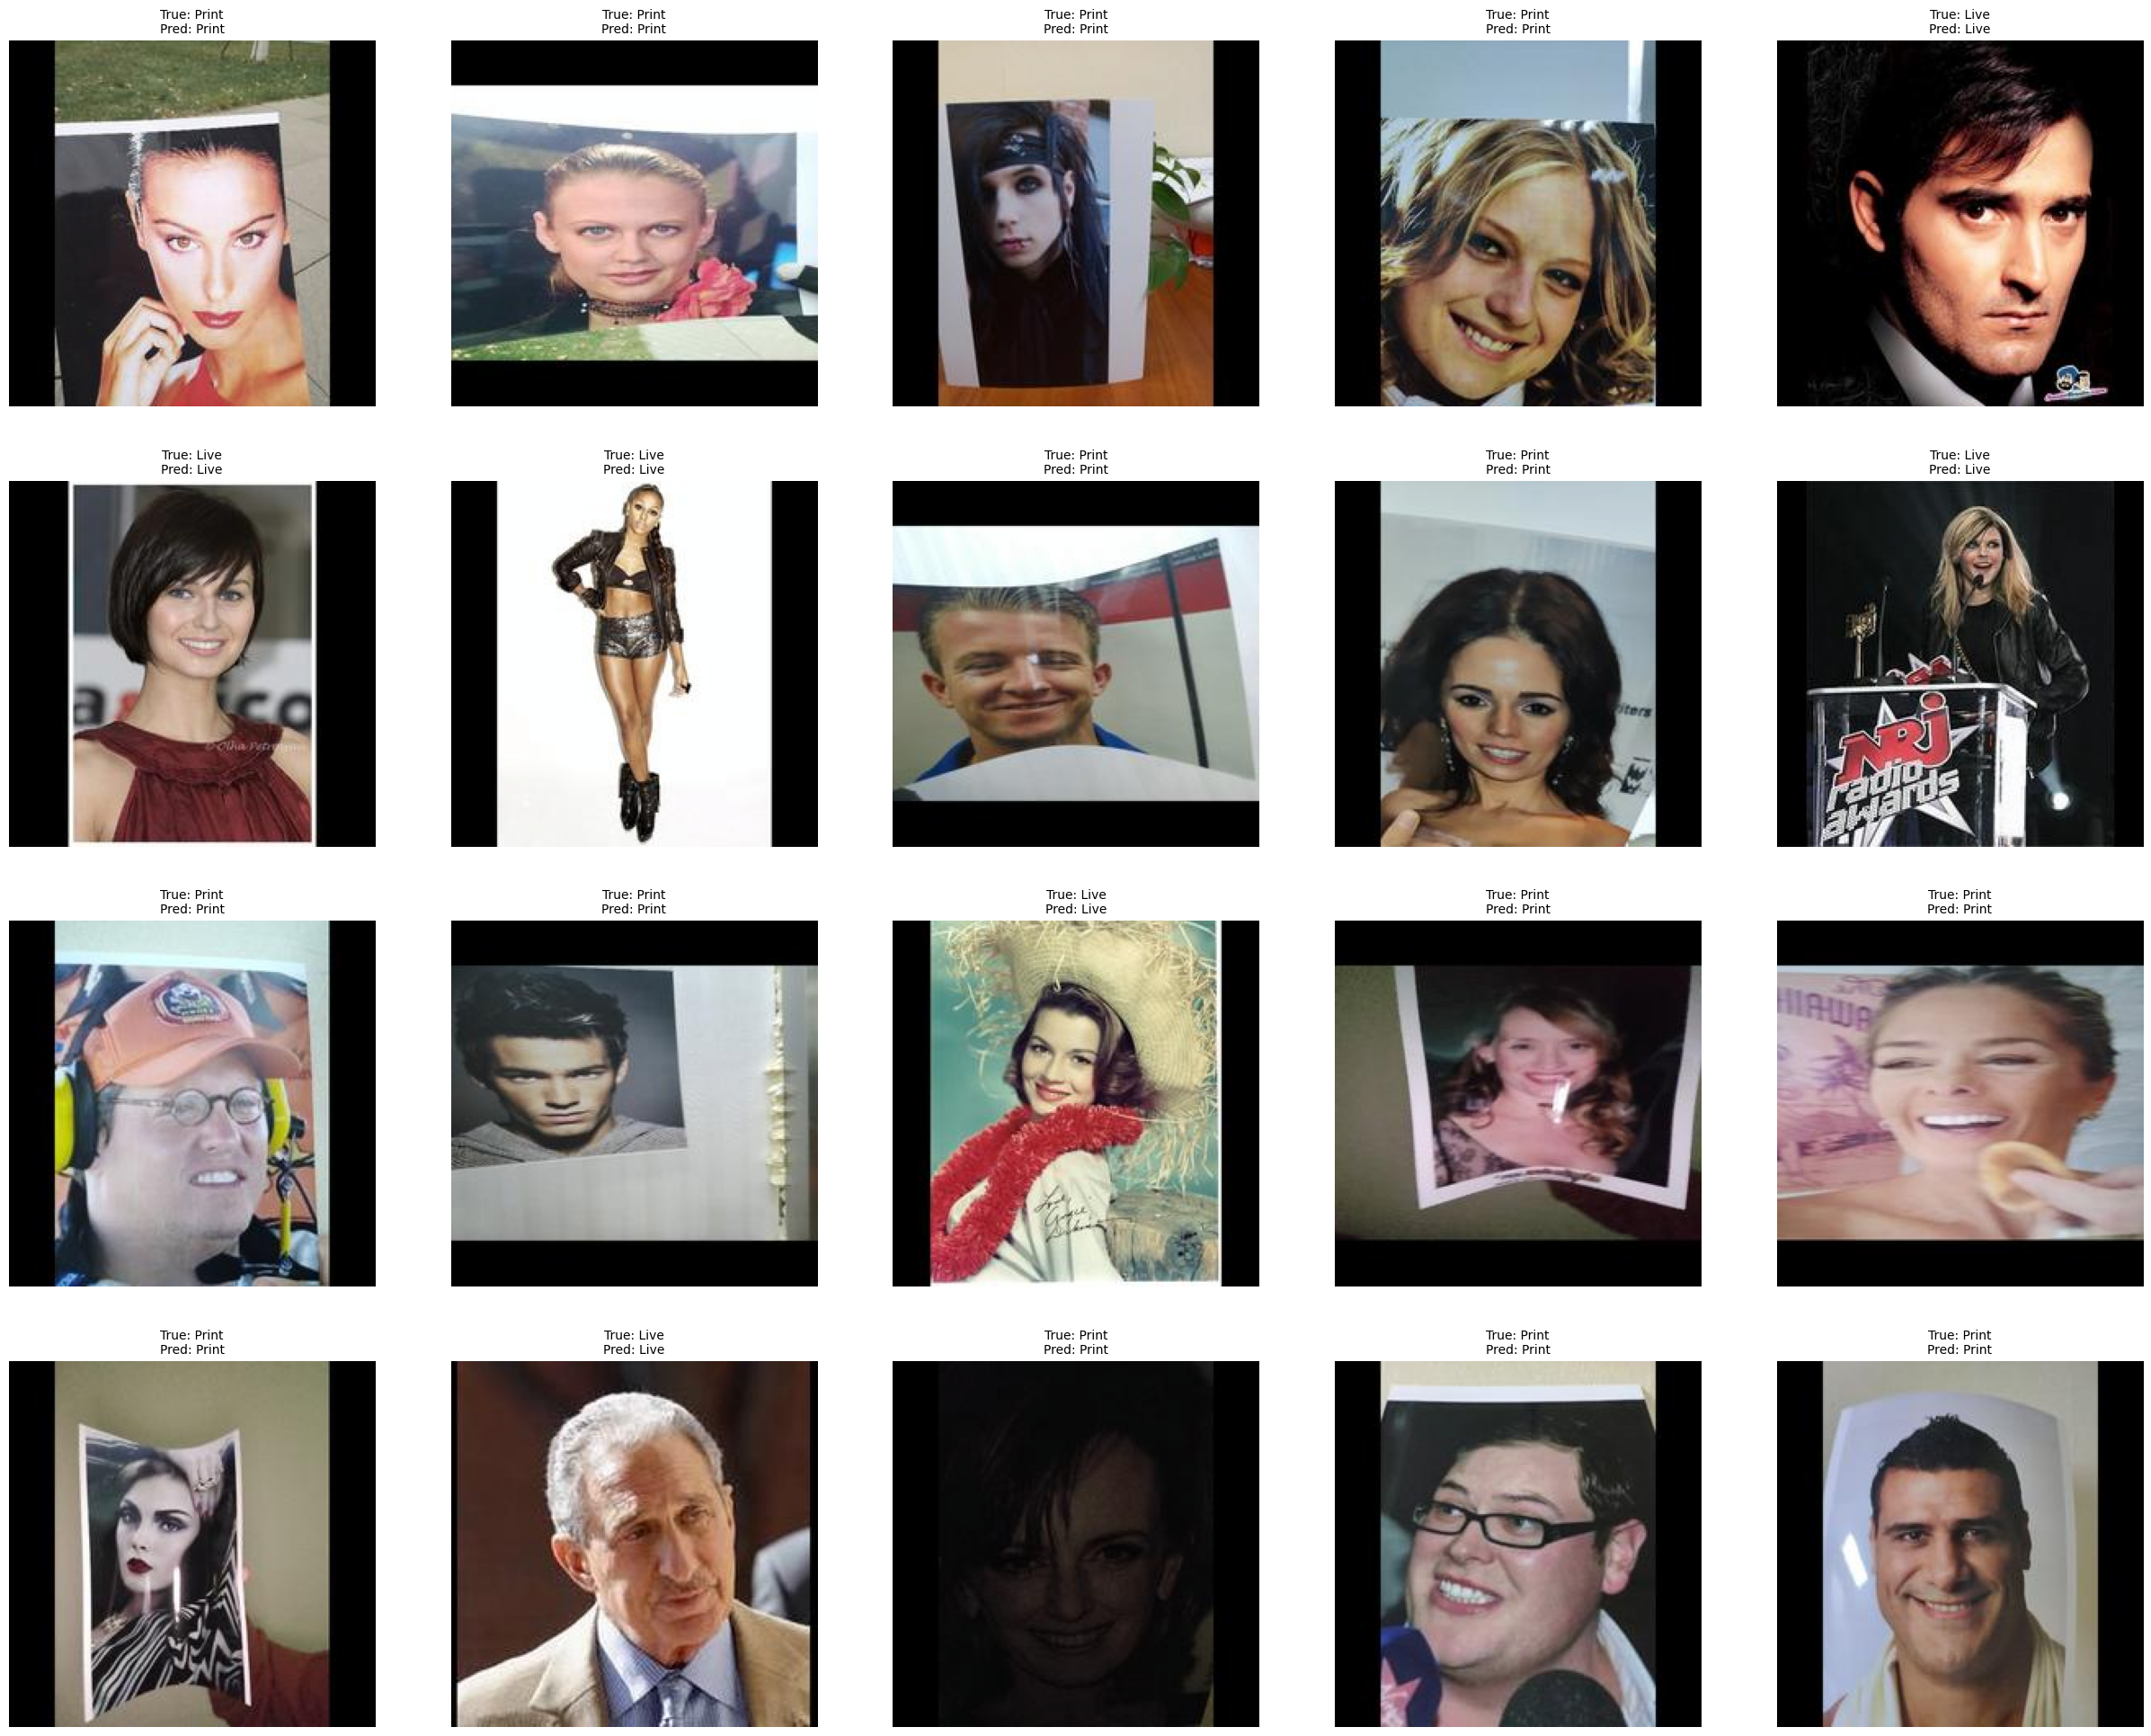

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

class_names = {0: "Live", 1: "Print", 2: "Papercut", 3: "Replay", 4: "3D"}
model.eval()

# Get a batch of images from the DataLoader
images, labels = next(iter(dataloaders['val']))

images = images.to(device)
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

images_np = images.cpu().numpy()

def unnormalize(image):
    image_transposed = np.transpose(image, (1, 2, 0))
    image_transposed = image_transposed * std + mean
    image_transposed = np.clip(image_transposed, 0, 1)  # Clip to ensure [0, 1] range
    return np.transpose(image_transposed, (2, 0, 1))

images_np = np.array([unnormalize(img) for img in images_np])

indices = np.random.choice(len(images_np), 20, replace=False)

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(25, 20))
fig.tight_layout(pad=3.0)

for i, idx in enumerate(indices):
    ax = axes[i // 5, i % 5]
    img = np.transpose(images_np[idx], (1, 2, 0))
    ax.imshow(img)
    ax.set_title(f"True: {class_names[labels[idx].item()]}\nPred: {class_names[preds[idx].item()]}", fontsize=10)
    ax.axis('off')

plt.show()
